In [1]:
# 이번에는 같은 코드를 텐서플로우로 짜보겠습니다
# 다른 부분은 별다른 차이가 없지만 학습시키는 부분에서 좀 차이가 있습니다
# 중복되는 설명은 배제했습니다
# numpy만 사용한 3-1 코드를 옆에 켜놓고 보시면 비교가 편합니다

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline 

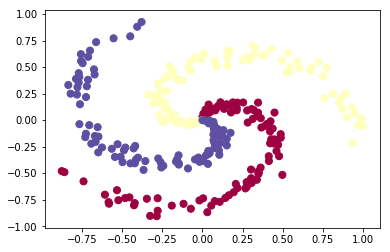

In [2]:
N = 100 
D = 2 
K = 3 
H = 100 # hidden layer node 수
X = np.zeros((N*K,D)) 
y = np.zeros(N*K, dtype='uint8') 

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix]= j

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Spectral)

In [3]:
# 이 부분은 뒤에 사용할 텐서플로우 api의 함수에 맞게 
# y를 (300,1)에서 (300,3)으로 변형시킨것입니다 
# 예를들어 (2)였다면 (0,0,1)로 바꿨습니다

new_y=np.zeros([N*K,K])
for i in range(N*K):
	new_y[i,y[i]]=1

In [4]:
# hyperparameter 설정입니다 
# 원래는 맨 위에 적어놓는데 설명의 흐름에 맞춰 여기에 배정했습니다 

learning_rate=1e-2
reg_lambda=1e-2
iteration=10000
num_examples=X.shape[0]

In [5]:
# placeholder와 varaible을 설정합니다

x =tf.placeholder(shape=[300,2],dtype=tf.float32,name='x') # feed X
y_=tf.placeholder(shape=[300,3],dtype=tf.float32,name='y_') # feed new_y

w1=tf.Variable(0.01*np.random.rand(D,H)/np.sqrt(D/2),dtype=tf.float32,name='w1')
b1=tf.Variable(np.zeros([1,H]),dtype=tf.float32,name='b1' )
w2=tf.Variable(0.01*np.random.rand(H,3)/np.sqrt(H/2),dtype=tf.float32,name='w2')
b2=tf.Variable(np.zeros([1,K]),dtype=tf.float32,name='b2' )

In [7]:
# forward,loss,accuracy를 그냥 numpy만 쓰면 25줄이 넘어가는데 텐서플로우를 사용하면 5줄이면 끝납니다
# backpropagation 부분은 명시적으로 쓰지 않아도 자동으로 계산되어 업데이트 됩니다
# 이 부분이 그냥 numpy를 사용하는것보다 엄청난 장점이고 
# tf.nn.relu, tf.nn.softmax_cross_entropy_with_logits, tf.train.GradientDescentOptimizer 
# 같은 함수들이 이미 구현되어 있어서 상당히 편리합니다
# 이외에도 그래프의 전체흐름을 시각화해주는 tensorboard, model save & restore, gpu 연산 등 다양한 장점이 있습니다 

hidden_layer= tf.nn.relu(tf.matmul(x,w1)+b1)
output_layer=tf.matmul(hidden_layer,w2)+b2
cross_entropy_loss=tf.nn.softmax_cross_entropy_with_logits(logits=output_layer,labels=y_)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_loss)
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output_layer,1),tf.argmax(y_,1)),dtype=tf.float32))

In [8]:
# 세션을 돌리기 전에 필요한것들을 준비해 놓습니다

feed_dict={x:X,y_:new_y}
init= tf.global_variables_initializer()

In [9]:
with tf.Session() as sess:
	sess.run(init)
	for x in range(iteration):
		_,acc=sess.run([train_step,accuracy],feed_dict=feed_dict)
		if x%1000==0:
			print(acc)
    
    # tf.Variable.eval 함수는 변수를 텐서에서 numpy.ndarray로 변환시켜줍니다
    # 뒷부분 plot을 재활용하기 위해 추가했습니다
	w1=w1.eval()
	b1=b1.eval()
	w2=w2.eval()
	b2=b2.eval()

0.27
0.99
0.993333
0.993333
0.993333
0.993333
0.99
0.993333
0.993333
0.993333


(-1.9057565489468211, 1.9142434510531823)

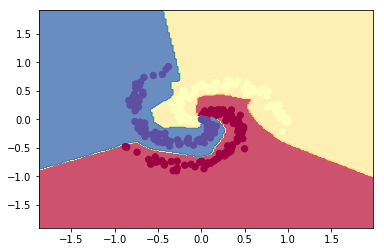

In [10]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())